In [ ]:
"""
Notes: Noise vs Standard SARSA Comparison

Observation
The agent trained with 20% action noise significantly outperforms when both are evaluated in the clean deterministic environment. 
Noise-trained agent achieved 8.34 average reward with 100% success rate vs the standard agent's much lower performance.

Important Correction
Initially though reward structures were different, but they're identical. The only difference is action execution reliability during training:
- Standard: Actions execute exactly as intended
- Noise: 20% chance of random action instead of intended action

Why This Works (My Understanding)
The noise acts like a forcing function for robustness. When you can't rely on actions executing perfectly, the agent has to learn more conservative, reliable policies. 
It's prolly like practicing with weighted gear - when you take the weights off, performance improves dramatically.


The Q-values learned under noise inherently account for uncertainty:
- Standard Q(s,a): "Expected return if action a works perfectly"
- Noise Q(s,a): "Expected return accounting for 20% action failure"

The second set of values is naturally more robust and generalizes better.
( Action noise acts as implicit regularization preventing overfitting to training conditions, looks like it improved generalization)

Broader Implications ("train hard, perform easy" principle in RL)
Similar to domain randomization in robotics - introducing controlled difficulty during training often leads to more capable agents in deployment.

Takeaway: Environmental stochasticity(noise) during training can sometimes be a feature that improves generalization.
"""

In [13]:
import gym
import numpy as np
import random
import math
np.bool = np.bool_

In [2]:
#A wrapper for Taxi-v3 that introduces action noise.With probability `action_noise_prob`, a random action is taken instead of the intended one.
class NoisyTaxiWrapper(gym.Wrapper):
    def __init__(self, env, action_noise_prob=0.1):
        super().__init__(env)
        self.action_noise_prob = action_noise_prob
        if not (0.0 <= self.action_noise_prob <= 1.0):
            raise ValueError("action_noise_prob must be between 0.0 and 1.0")
        print(f"NoisyTaxiWrapper initialized with action_noise_prob = {self.action_noise_prob}")

    def step(self, action):
        """
        Overrides the step method to potentially inject noise.
        """
        if random.random() < self.action_noise_prob:
            # Noise occurs: take a random action
            actual_action = self.env.action_space.sample()
            # print(f"NOISE! Intended: {action}, Actual: {actual_action}") # For debugging
        else:
            # No noise: take the intended action
            actual_action = action

        # Call the step method of the underlying environment with the (potentially modified) action
        return self.env.step(actual_action)

    #wrapper will pass other remaining calls to the original env by default.

#env = gym.make("Taxi-v3")
base_env = gym.make("Taxi-v3")
# Let's try with 20% action noise
noise_probability = 0.2
env = NoisyTaxiWrapper(base_env, action_noise_prob=noise_probability)
#noisy_env = NoisyTaxiWrapper(base_env, action_noise_prob=noise_probability)
#env = RewardShapingWrapper(noisy_env, new_step_penalty=-0.5, new_goal_reward=50)
#env=gym.make("Taxi-v3")


NoisyTaxiWrapper initialized with action_noise_prob = 0.2


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
#setting hyperparameters for sarsa strategy
epsilon=1.0
discount_factor=0.99
min_epsilon=0.05
max_epsilon=1
learning_rate=0.1
epsilon_decay_rate=0.00025

num_of_episodes=25000

#observations for epsilon_decay_rate
"""
when epsilon_decay_rate=0.05 -> epsilon value quickly drops to min epsilon value ( after 1000th episode) and the Agent explores less in next episodes, but still the avg reward per episode was >5 , guessing because there were only 500 state space
and this environment was quickly learnable, otherwise this algorithm would have failed to explore few good paths and learn less about its environment
Rule for my next attempts could be set up the decay rate way less or adjust such that the epsilon to reach min_epsilon (or be very close to it) towards the end of training episodes, not near the beginning

now setting epsilon_decay-rate=0.00025
this iteration let to several thousands of episodes getting negative reward, since the epsilon was high , the agent was just trying to explore more and deviate from its optimal strategy.
after the epsilon dropped to 0.1, the training was good.
But this probably is a good strtegy if we want the sarsa algo to fail badly initally and learn that there might be bad rewards if it fails and eventually decrease the epsilon and train & make it with good pahts that worked good
this way we can make this more safer and prod ready since the Q values are already optimized for safer routes for diff state action pairs
"""


'\nwhen epsilon_decay_rate=0.05 -> epsilon value quickly drops to min epsilon value ( after 1000th episode) and the Agent explores less in next episodes, but still the avg reward per episode was >5 , guessing because there were only 500 state space\nand this environment was quickly learnable, otherwise this algorithm would have failed to explore few good paths and learn less about its environment\nRule for my next attempts could be set up the decay rate way less or adjust such that the epsilon to reach min_epsilon (or be very close to it) towards the end of training episodes, not near the beginning\n\nnow setting epsilon_decay-rate=0.00025\nthis iteration let to several thousands of episodes getting negative reward, since the epsilon was high , the agent was just trying to explore more and deviate from its optimal strategy.\nafter the epsilon dropped to 0.1, the training was good.\nBut this probably is a good strtegy if we want the sarsa algo to fail badly initally and learn that there

In [7]:
num_states=env.observation_space.n
num_actions=env.action_space.n
q_table=np.zeros((num_states,num_actions))
print("Actions: 0=South, 1=North, 2=East, 3=West, 4=Pickup, 5=Dropoff")

rewards_all_episodes = []
#actual sarsa algo here
for episode in range(num_of_episodes):
  state=env.reset()
  current_episode_reward=0
  done=False
  random_action=random.uniform(0, 1)
  # selecting initial action A_t using policy derived from Q (epsilon-greedy) , this is the first diff between Q learning & sarsa
  if random_action<epsilon:
    action=env.action_space.sample() #explore
  else:
    action=np.argmax(q_table[state,:])

  while not done:
    next_state, reward, done, info = env.step(action)

    #another diff here for sarsa, current state is updated based on action of next state ( like a careful kid who walks slowly to make sure he doesn't fall)
    if random.uniform(0, 1) < epsilon:
      next_action = env.action_space.sample() # explore
    else:
      next_action = np.argmax(q_table[next_state,:]) # exploit

    if done:
      q_table[state,action] = q_table[state,action] + learning_rate * ( reward - q_table[state,action])
    else:
      q_table[state,action] = q_table[state,action] + learning_rate * ( reward + discount_factor * q_table[next_state,next_action] - q_table[state,action])

    state=next_state
    action=next_action

    current_episode_reward += reward

  epsilon = min_epsilon + (max_epsilon - min_epsilon) * math.exp(-epsilon_decay_rate * episode)

  # Store episode reward for analysis
  rewards_all_episodes.append(current_episode_reward)

  # Print progress every 1000 episodes
  if (episode + 1) % 1000 == 0:
      #clear_output(wait=True)
      avg_reward = np.mean(rewards_all_episodes[-1000:])  # Average of last 1000 episodes
      print(f"Episode: {episode + 1}/{num_of_episodes}")
      print(f"Epsilon: {epsilon:.3f}")
      print(f"Average reward (last 1000 episodes): {avg_reward:.2f}")
      print(f"Current episode reward: {current_episode_reward}")
      print("-" * 50)

Actions: 0=South, 1=North, 2=East, 3=West, 4=Pickup, 5=Dropoff
Episode: 1000/25000
Epsilon: 0.790
Average reward (last 1000 episodes): -680.17
Current episode reward: -572
--------------------------------------------------
Episode: 2000/25000
Epsilon: 0.626
Average reward (last 1000 episodes): -432.64
Current episode reward: -77
--------------------------------------------------
Episode: 3000/25000
Epsilon: 0.499
Average reward (last 1000 episodes): -236.17
Current episode reward: -75
--------------------------------------------------
Episode: 4000/25000
Epsilon: 0.400
Average reward (last 1000 episodes): -114.62
Current episode reward: -114
--------------------------------------------------
Episode: 5000/25000
Epsilon: 0.322
Average reward (last 1000 episodes): -63.25
Current episode reward: -31
--------------------------------------------------
Episode: 6000/25000
Epsilon: 0.262
Average reward (last 1000 episodes): -40.36
Current episode reward: -70
----------------------------------

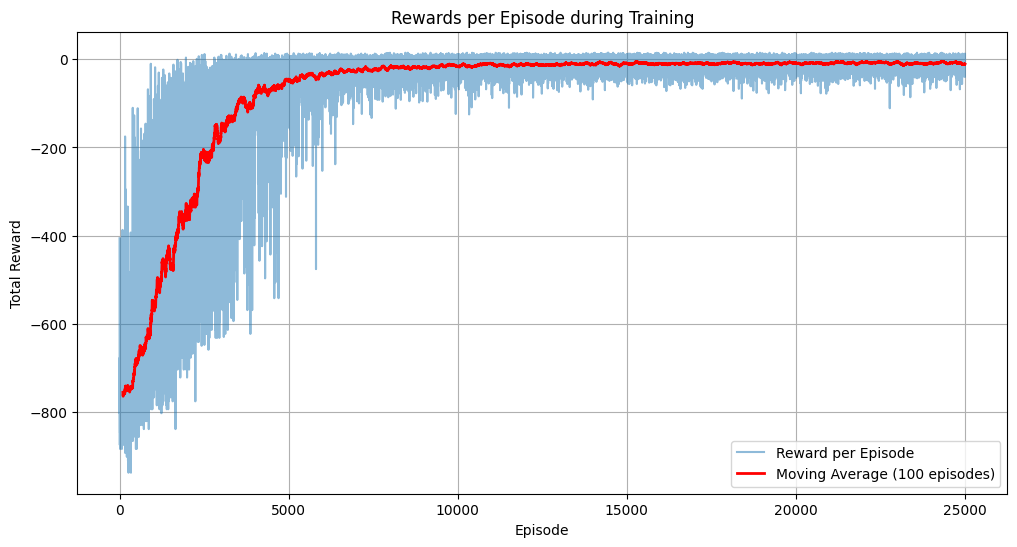

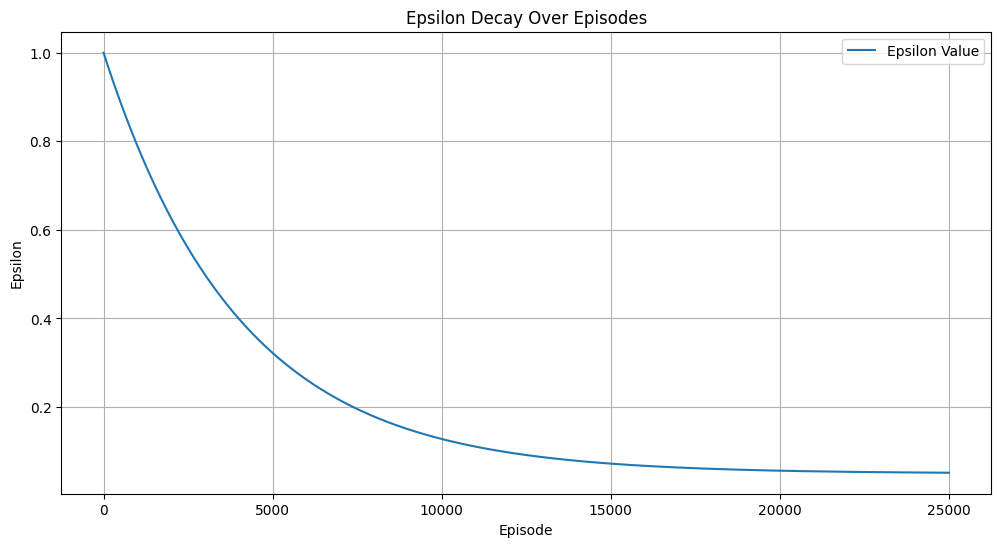

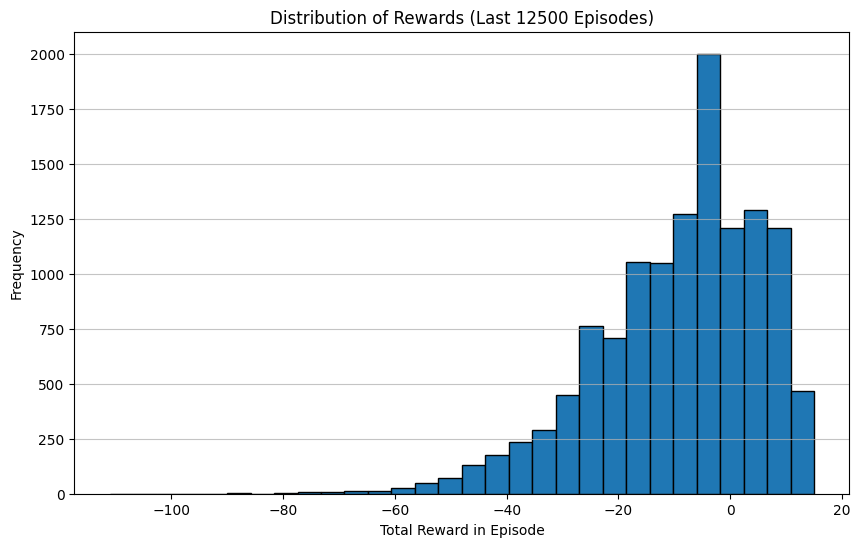

Number of episodes plotted: 25000
Final moving average reward (last 100 episodes of the moving average): -10.61

Summary Statistics for All Episodes:
Average reward: -71.99
Standard deviation of reward: 170.56
Max reward: 15.00
Min reward: -938.00

Summary Statistics for Last 10% of Episodes (2500 episodes):
Average reward: -8.85
Standard deviation of reward: 14.39
Max reward: 15.00
Min reward: -111.00


In [8]:
import matplotlib.pyplot as plt

# Calculate a moving average of rewards to smooth out the curve
# This makes it easier to see trends.
window_size = 100 # Plot average reward over this many episodes
if len(rewards_all_episodes) >= window_size:
    moving_avg_rewards = np.convolve(rewards_all_episodes, np.ones(window_size)/window_size, mode='valid')
else:
    # Handle cases where there are fewer episodes than the window size
    # For simplicity, we can just plot the raw rewards or a smaller window
    moving_avg_rewards = rewards_all_episodes
    print(f"Warning: Fewer episodes ({len(rewards_all_episodes)}) than moving average window ({window_size}). Plotting raw or partially averaged rewards.")


# 1. Plot of Rewards per Episode (with Moving Average)
plt.figure(figsize=(12, 6))
plt.plot(rewards_all_episodes, label='Reward per Episode', alpha=0.5) # Raw rewards
if len(moving_avg_rewards) > 0: # Ensure moving_avg_rewards is not empty
    # Adjust x-axis for moving average to align it properly
    # The moving average starts after 'window_size - 1' episodes
    plt.plot(np.arange(window_size -1, len(rewards_all_episodes)), moving_avg_rewards, label=f'Moving Average ({window_size} episodes)', color='red', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode during Training')
plt.legend()
plt.grid(True)
plt.show()

# 2. Plot of Epsilon Decay (Optional, but jus for sanity check)
plt.figure(figsize=(12, 6))
epsilon_values_over_episodes = [min_epsilon + (max_epsilon - min_epsilon) * math.exp(-epsilon_decay_rate * ep) for ep in range(num_of_episodes)]
plt.plot(epsilon_values_over_episodes, label='Epsilon Value')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Over Episodes')
plt.legend()
plt.grid(True)
plt.show()

# 3. Distribution of Final Rewards (Histogram)
# This can give you an idea of the consistency of the agent's performance
# especially towards the end of training.
plt.figure(figsize=(10, 6))
# Consider plotting rewards from the latter half of training for a more stable view
num_episodes_for_hist = len(rewards_all_episodes) // 2
plt.hist(rewards_all_episodes[-num_episodes_for_hist:], bins=30, edgecolor='black')
plt.xlabel('Total Reward in Episode')
plt.ylabel('Frequency')
plt.title(f'Distribution of Rewards (Last {num_episodes_for_hist} Episodes)')
plt.grid(axis='y', alpha=0.75)
plt.show()

print(f"Number of episodes plotted: {len(rewards_all_episodes)}")
if len(moving_avg_rewards) > 0:
    print(f"Final moving average reward (last {window_size} episodes of the moving average): {moving_avg_rewards[-1]:.2f}")
else:
    print("Not enough data for final moving average reward.")

# You can also print some summary statistics
print(f"\nSummary Statistics for All Episodes:")
print(f"Average reward: {np.mean(rewards_all_episodes):.2f}")
print(f"Standard deviation of reward: {np.std(rewards_all_episodes):.2f}")
print(f"Max reward: {np.max(rewards_all_episodes):.2f}")
print(f"Min reward: {np.min(rewards_all_episodes):.2f}")

# Statistics for the latter part of training (e.g., last 10% of episodes)
last_10_percent_idx = int(len(rewards_all_episodes) * 0.9)
if last_10_percent_idx < len(rewards_all_episodes): # Ensure there are enough episodes
    rewards_last_10_percent = rewards_all_episodes[last_10_percent_idx:]
    print(f"\nSummary Statistics for Last 10% of Episodes ({len(rewards_last_10_percent)} episodes):")
    print(f"Average reward: {np.mean(rewards_last_10_percent):.2f}")
    print(f"Standard deviation of reward: {np.std(rewards_last_10_percent):.2f}")
    print(f"Max reward: {np.max(rewards_last_10_percent):.2f}")
    print(f"Min reward: {np.min(rewards_last_10_percent):.2f}")

In [16]:
# --- EVALUATION OF THE TRAINED AGENT ---

num_evaluation_episodes = 100
total_rewards_eval = 0
total_steps_eval = 0
successful_deliveries = 0
#updating env to default to test out how agent performs in normal environment after it was trained in noise events
env = gym.make("Taxi-v3",disable_env_checker=True)
np.bool = np.bool_
print("\n--- Starting Evaluation ---")

for episode in range(num_evaluation_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        # Choose action based purely on learned Q-values (exploitation)
        action = np.argmax(q_table[state, :])

        next_state, reward, done, info = env.step(action)

        state = next_state
        episode_reward += reward
        episode_steps += 1

        if done:
            if reward == 20: # Standard reward for successful drop-off in Taxi-v3
                successful_deliveries += 1
            break # Exit while loop for this episode

    total_rewards_eval += episode_reward
    total_steps_eval += episode_steps

    if (episode + 1) % 10 == 0:
        print(f"Evaluation Episode: {episode + 1}/{num_evaluation_episodes} | Reward: {episode_reward} | Steps: {episode_steps}")

# Calculate average statistics
avg_reward_eval = total_rewards_eval / num_evaluation_episodes
avg_steps_eval = total_steps_eval / num_evaluation_episodes
success_rate_eval = (successful_deliveries / num_evaluation_episodes) * 100

print("\n--- Evaluation Finished ---")
print(f"Total Episodes Evaluated: {num_evaluation_episodes}")
print(f"Average Reward per Episode: {avg_reward_eval:.2f}")
print(f"Average Steps per Episode: {avg_steps_eval:.2f}")
print(f"Success Rate (successful deliveries): {success_rate_eval:.2f}%")

# Compare with training performance (last 10% of training)
if 'rewards_last_10_percent' in locals() and len(rewards_last_10_percent) > 0:
    print(f"\nFor comparison (last 10% of training):")
    print(f"  Average reward: {np.mean(rewards_last_10_percent):.2f}")
else:
    print("\n(Training statistics for comparison not available in this session(run training cell again))")


--- Starting Evaluation ---
Evaluation Episode: 10/100 | Reward: 9 | Steps: 12
Evaluation Episode: 20/100 | Reward: 5 | Steps: 16
Evaluation Episode: 30/100 | Reward: 4 | Steps: 17
Evaluation Episode: 40/100 | Reward: 7 | Steps: 14
Evaluation Episode: 50/100 | Reward: 9 | Steps: 12
Evaluation Episode: 60/100 | Reward: 14 | Steps: 7
Evaluation Episode: 70/100 | Reward: 6 | Steps: 15
Evaluation Episode: 80/100 | Reward: 8 | Steps: 13
Evaluation Episode: 90/100 | Reward: 10 | Steps: 11
Evaluation Episode: 100/100 | Reward: 8 | Steps: 13

--- Evaluation Finished ---
Total Episodes Evaluated: 100
Average Reward per Episode: 8.34
Average Steps per Episode: 12.66
Success Rate (successful deliveries): 100.00%

For comparison (last 10% of training):
  Average reward: -8.85


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


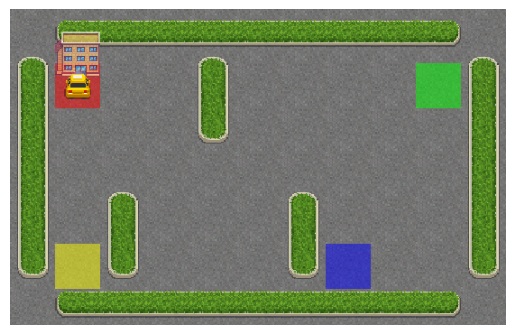

Episode Finished after 12 steps!
Final Reward for this episode: 9
Passenger delivered successfully!


In [21]:
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

#trying to visualize with trained parameters

print("\n--- Visualizing One Episode ---")
state = env.reset()
done = False
max_steps_visualization = 50 # Set a max steps to prevent infinite loop if something is wrong
total_episode_reward_viz = 0


# env.render(mode='human') would open a window, if running in local system

for step_viz in range(max_steps_visualization):
    clear_output(wait=True) # to cllear the previous frame

    try:
        rendered_frame = env.render(mode='rgb_array')
        if rendered_frame is not None:
            plt.imshow(rendered_frame)
            plt.axis('off') # Turn off axis numbers and ticks
            plt.show()
        else:
            #fallback if it doesnot render This just prints text representation
            print(f"Step: {step_viz + 1}")
            env.render(mode='ansi') # Renders text-based to console output

    except Exception as e:
        print(f"Rendering error: {e}. Falling back to ANSI render.")
        env.render(mode='ansi')


    print(f"Current State: {state}, Total Reward: {total_episode_reward_viz}")

    # whichever action has max Q value we choose it
    action = np.argmax(q_table[state, :])

    next_state, reward, done, info = env.step(action)

    state = next_state
    total_episode_reward_viz += reward

    time.sleep(0.5) # Pausing here for 1/2 second to see frame

    if done:
        clear_output(wait=True)
        try:
            rendered_frame = env.render(mode='rgb_array')
            if rendered_frame is not None:
                plt.imshow(rendered_frame)
                plt.axis('off')
                plt.show()
            else:
                env.render(mode='ansi')
        except Exception as e:
            print(f"Rendering error on final step: {e}. Falling back to ANSI render.")
            env.render(mode='ansi')

        print(f"Episode Finished after {step_viz + 1} steps!")
        print(f"Final Reward for this episode: {total_episode_reward_viz}")
        if reward == 20:
            print("Passenger delivered successfully!")
        else:
            print("Episode ended for other reasons (e.g., max steps in a real scenario, or unexpected outcome).")
        break

if not done:
    print("Visualization stopped due to max_steps_visualization limit.")

# env.close() # Important if you used mode='human' or if render creates resources.
# For 'rgb_array' and 'ansi' it's often not strictly necessary but good practice.

In [ ]:
#running below modules to render this frames into a video
!pip install imageio
!pip install imageio-ffmpeg # For saving as MP4, imageio might need this backend

In [ ]:
import time
import imageio
import numpy as np # Make sure numpy is imported

# --- CONFIGURATION ---
num_episodes_to_record = 25
max_steps_per_episode_viz = 50 # Max steps for each visualized episode
video_filename_mp4 = f'taxi_sarsa_{num_episodes_to_record}_episodes.mp4'
video_filename_gif = f'taxi_sarsa_{num_episodes_to_record}_episodes.gif' # Fallback
fps_video = 10 # Frames per second - adjust for desired speed

# --- FRAME COLLECTION ACROSS MULTIPLE EPISODES ---
print(f"\n--- Collecting frames for {num_episodes_to_record} episodes ---")
all_frames = [] # List to store all frames from all episodes

for episode_num in range(num_episodes_to_record):
    print(f"\nStarting episode {episode_num + 1}/{num_episodes_to_record} for video recording...")
    state = env.reset()
    done = False
    total_episode_reward_viz = 0

    # Optional: Add a "title card" frame for each new episode
    # This requires creating an image with text, which can be done with Pillow or OpenCV
    # For simplicity, we'll skip this for now, but it's an idea for better separation.

    # Render and append the initial state of the episode
    try:
        initial_frame = env.render(mode='rgb_array')
        if initial_frame is not None:
            all_frames.append(initial_frame)
        else:
            print(f"Warning: Initial RGB frame for episode {episode_num + 1} is None.")
    except Exception as e:
        print(f"Error rendering initial frame for episode {episode_num + 1}: {e}")

    for step_viz in range(max_steps_per_episode_viz):
        action = np.argmax(q_table[state, :]) # Exploit learned policy
        next_state, reward, done, info = env.step(action)

        current_frame_rgb = None
        try:
            current_frame_rgb = env.render(mode='rgb_array')
            if current_frame_rgb is not None:
                all_frames.append(current_frame_rgb)
            else:
                print(f"Warning: RGB frame is None at ep {episode_num+1}, step {step_viz + 1}.")
        except Exception as e:
            print(f"Error rendering frame at ep {episode_num+1}, step {step_viz + 1}: {e}")

        state = next_state
        total_episode_reward_viz += reward

        if done:
            print(f"Episode {episode_num + 1} finished after {step_viz + 1} steps. Reward: {total_episode_reward_viz}")
            # Optional: Add a few duplicate frames of the final state to make it pause longer
            # if current_frame_rgb is not None:
            #     for _ in range(fps_video // 2): # Pause for 0.5 seconds
            #         all_frames.append(current_frame_rgb)
            break

    if not done:
        print(f"Episode {episode_num + 1} stopped due to max_steps_visualization limit ({max_steps_per_episode_viz} steps). Reward: {total_episode_reward_viz}")

print(f"\n--- Frame collection finished. Total frames collected: {len(all_frames)} ---")

# --- SAVE THE COLLECTED FRAMES AS A SINGLE VIDEO ---
if len(all_frames) > 1:
    try:
        print(f"\nSaving MP4 video to {video_filename_mp4} ({len(all_frames)} frames at {fps_video} FPS)...")
        imageio.mimsave(video_filename_mp4, all_frames, fps=fps_video)
        print(f"MP4 video saved successfully!")
    except Exception as e_mp4:
        print(f"Error saving MP4: {e_mp4}")
        print(f"Attempting to save as GIF instead to {video_filename_gif}...")
        try:
            imageio.mimsave(video_filename_gif, all_frames, fps=fps_video, loop=0)
            print(f"GIF saved successfully to {video_filename_gif}!")
        except Exception as e_gif:
            print(f"Error saving GIF: {e_gif}")
            print("Could not save video in any format.")
elif all_frames:
    print("\nOnly one frame was collected. Cannot create a video.")
else:
    print("\nNo frames were collected. Cannot save video. Ensure env.render(mode='rgb_array') is working.")

# env.close()


--- Collecting frames for 25 episodes ---

Starting episode 1/25 for video recording...
Episode 1 finished after 8 steps. Reward: 13

Starting episode 2/25 for video recording...
Episode 2 finished after 13 steps. Reward: 8

Starting episode 3/25 for video recording...
Episode 3 finished after 11 steps. Reward: 10

Starting episode 4/25 for video recording...
Episode 4 finished after 12 steps. Reward: 9

Starting episode 5/25 for video recording...
Episode 5 finished after 15 steps. Reward: 6

Starting episode 6/25 for video recording...
Episode 6 finished after 16 steps. Reward: 5

Starting episode 7/25 for video recording...
Episode 7 finished after 15 steps. Reward: 6

Starting episode 8/25 for video recording...
Episode 8 finished after 13 steps. Reward: 8

Starting episode 9/25 for video recording...
Episode 9 finished after 9 steps. Reward: 12

Starting episode 10/25 for video recording...
Episode 10 finished after 11 steps. Reward: 10

Starting episode 11/25 for video recording

Episode 25 finished after 17 steps. Reward: 4

--- Frame collection finished. Total frames collected: 339 ---

Saving MP4 video to taxi_sarsa_25_episodes.mp4 (339 frames at 10 FPS)...
MP4 video saved successfully!
